In [1]:
import keras
from keras.layers import Conv2D,Concatenate, Conv2DTranspose, UpSampling2D,UpSampling3D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer,Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get images

def load_image_directory(path):
    images = []
    
    images_name = os.listdir(path)
    images_name.sort()
    
    for filename in images_name:
        images.append(img_to_array(load_img('{0}{1}'.format(path, filename))))
    images = np.array(images, dtype=float)
    
    return images

colored_images = load_image_directory('./TrainFlowers/')[50:]
grey_images = load_image_directory('./BWnew/')[50:]

data = list(zip(grey_images, colored_images))
np.random.shuffle(data)

x = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

x = 1.0/255 * x
y = 1.0/255* y

x = rgb2lab(x)[:,:,:,0]
y1= rgb2lab(y)[:,:,:,0]
x = x.reshape(x.shape+(1,))
y1 = y1.reshape(y1.shape+(1,))
print("finished loading")

finished loading


In [18]:
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)


SRCNN = Sequential()
SRCNN.add(InputLayer(input_shape=(32, 32, 1)))
SRCNN.add(UpSampling2D((3, 3),name='outmodel'))
SRCNN.add(Conv2D(128, (3,3), init='glorot_uniform',
          activation='relu',bias=True, border_mode='same'))
SRCNN.add(Conv2D(64, (3,3), init='glorot_uniform',
          activation='relu', border_mode='same'))
SRCNN.add(Conv2D(32, (3,3), init='glorot_uniform',
          activation='relu', border_mode='same'))
SRCNN.add(Conv2D(16, (3,3), init='glorot_uniform',
          activation='relu', border_mode='same'))
SRCNN.add(Conv2D(1, (3,3), init='glorot_uniform',
                     activation='linear', border_mode='same'))

SRCNN.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])

print(SRCNN.summary())
print("created model")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
outmodel (UpSampling2D)      (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 96, 96, 128)       1280      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 96, 96, 64)        73792     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 32)        18464     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 96, 96, 16)        4624      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 96, 96, 1)         145       
Total para

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_initializer="glorot_uniform", padding="same", use_bias=True, activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  
/usr/local/lib/python3.5/dist-pac

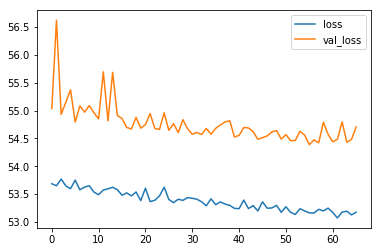

(96, 96, 1)


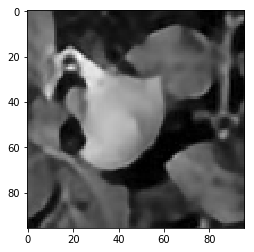

(32, 32, 1)


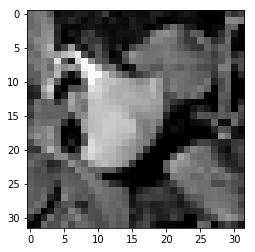

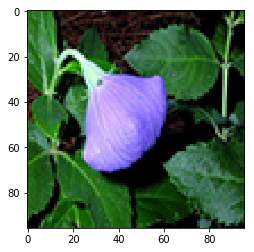

Epoch 00066: val_loss did not improve
7325/7325 [==============================] - 34s 5ms/step - loss: 53.1737 - mean_squared_error: 53.1737 - val_loss: 54.7041 - val_mean_squared_error: 54.7041
Epoch 67/500
6200/7325 [========================>.....] - ETA: 4s - loss: 53.0896 - mean_squared_error: 53.0896

In [ ]:
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Image transformer
datagen = ImageDataGenerator()
batch_size = 50
epochs = 500

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        test = SRCNN.predict(np.array([x[0]]))
        cur = np.zeros((96, 96, 3))
        print(test[0].shape)
        cur[:,:,0] = np.reshape(test[0],(96,96))
        plt.imshow(lab2rgb(cur))
        plt.pause(0.05)
        
        cur = np.zeros((32, 32, 3))
        print(x[0].shape)
        cur[:,:,0] = np.reshape(x[0],(32,32))
        plt.imshow(lab2rgb(cur))
        
        plt.pause(0.05)
        plt.imshow(y[0])
        plt.pause(0.05)
        
plot_losses = PlotLosses()

filepath = 'SR-niv-allexamples-ep{epoch:03d}-loss{loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')       
# Train model      
print("starting")

SRCNN.fit(x, [y1],  # this is our training examples & labels
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,  # this parameter control the % of train data used for validation
          shuffle=True,
          callbacks=[plot_losses,checkpoint])  # this prints our loss at the end of every epoch

# Score trained model.
scores = model.evaluate(x, y, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

print("finished")

In [ ]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

In [ ]:
import matplotlib.pyplot as plt

color_me = []

grey_images = load_image_directory('./BWFlowers/')[:50]
color_me = np.array(grey_images, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(5):
    cur = np.zeros((96, 96, 3))
    cur[:,:,0] = np.reshape(color_me[i])
    cur[:,:,1:] = output[i]
    print(output[i].shape)
    plt.imshow(lab2rgb(cur))
    plt.pause(0.05)
    